In [ ]:
"""
Purpose: Finalizing the spine extraction portion from a certain branch
"""

In [1]:
from os import sys
sys.path.append("../../meshAfterParty/")
from importlib import reload

import os
from pathlib import Path
os.getcwd()

'/notebooks/Platinum_Spine_vp2'

In [2]:
compressed_neuron_path = Path("../test_neurons/test_objects/12345_2_soma_practice_decompress")

import neuron_utils as nru
nru = reload(nru)
import neuron
neuron=reload(neuron)

import system_utils as su

with su.suppress_stdout_stderr():
    recovered_neuron = nru.decompress_neuron(filepath=compressed_neuron_path,
                      original_mesh=compressed_neuron_path)

recovered_neuron


In [3]:
"""
Pseudocode: 
1) make sure the cgal temp folder exists
2) run the segmentation command
3) Read int csv 
4) Visualize the results using the graph function

"""
import cgal_Segmentation_Module as csm
from pathlib import Path
import trimesh_utils as tu
import numpy as np
import numpy_utils as nu
import skeleton_utils as sk
import copy

def split_mesh_into_spines_shaft(current_mesh,
                           segment_name="",
                           clusters=2,
                          smoothness=0.03,
                          cgal_folder = Path("./cgal_temp"),
                          delete_temp_file=True,
                          shaft_threshold = 300,
                                print_flag = True):

    if not cgal_folder.exists():
        cgal_folder.mkdir(parents=True,exist_ok=False)

    file_to_write = cgal_folder / Path(f"segment_{segment_name}.off")

    written_file_location = tu.write_neuron_off(current_mesh,file_to_write)

    if written_file_location[-4:] == ".off":
        cgal_mesh_file = written_file_location[:-4]
    else:
        cgal_mesh_file = written_file_location

    print(f"Going to run cgal segmentation with:"
         f"\nFile: {cgal_mesh_file} \nclusters:{clusters} \nsmoothness:{smoothness}")

    csm.cgal_segmentation(cgal_mesh_file,clusters,smoothness)

    #read in the csv file
    cgal_output_file = Path(cgal_mesh_file + "-cgal_" + str(np.round(clusters,2)) + "_" + "{:.2f}".format(smoothness) + ".csv" )

    cgal_data = np.genfromtxt(str(cgal_output_file.absolute()), delimiter='\n')

    #get a look at how many groups and what distribution:
    from collections import Counter
    print(f"Counter of data = {Counter(cgal_data)}")

    split_meshes,split_meshes_idx = tu.split_mesh_into_face_groups(current_mesh,cgal_data,return_idx=True,
                                   check_connect_comp = False)
    
    
    if len(split_meshes.keys()) <= 1:
        print("There was only one mesh found from the spine process and mesh split, returning empty array")
        return [],[],[],[]
        
    
#     # How to identify just one shaft
#     shaft_index = -1
#     shaft_total = -1
#     for k,v in split_meshes.items():
#         curr_length = len(v.faces)
#         if  curr_length > shaft_total:
#             shaft_index = k
#             shaft_total = curr_length
    
#     shaft_mesh = split_meshes.pop(shaft_index)
#     shaft_mesh_idx = split_meshes_idx.pop(shaft_index)
    
#     print(f"shaft_index = {shaft_index}")
    
    shaft_meshes = []
    shaft_meshes_idx = []
    
    spine_meshes = []
    spine_meshes_idx = []
    
    #Applying a length threshold to get all other possible shaft meshes
    for spine_id,spine_mesh in split_meshes.items():
        if len(spine_mesh.faces) < shaft_threshold:
            spine_meshes.append(spine_mesh)
            spine_meshes_idx.append(split_meshes_idx[spine_id])
        else:
            shaft_meshes.append(spine_mesh)
            shaft_meshes_idx.append(split_meshes_idx[spine_id])
 
    if len(shaft_meshes) == 0:
        if print_flag:
            print("No shaft meshes detected")
        return [],[],[],[]
 
    if len(spine_meshes) == 0:
        if print_flag:
            print("No spine meshes detected")

    if delete_temp_file:
        file_to_write.unlink()
        
    return spine_meshes,spine_meshes_idx,shaft_meshes,shaft_meshes_idx

current_neuron = recovered_neuron
branch_idx = 0
limb_idx = 0
current_mesh = recovered_neuron.concept_network.nodes[nru.limb_label(limb_idx)]["data"].concept_network.nodes[branch_idx]["data"].mesh
(spine_meshes,
 spine_meshes_idx,
 shaft_meshes,
 shaft_meshes_idx) = spine_data_returned= split_mesh_into_spines_shaft(current_mesh,
                           segment_name=f"{limb_idx}_{branch_idx}",
                           clusters=2,
                          smoothness=0.05,
                          cgal_folder = Path("./cgal_temp"),
                          delete_temp_file=True)

if len(spine_meshes) > 0:
    sk.graph_skeleton_and_mesh(
                           #main_mesh_verts = shaft_mesh.vertices,
                           #main_mesh_faces = shaft_mesh.faces,
                           #main_mesh_color="black",
                          other_meshes=spine_meshes,
                          other_meshes_colors="random",
                           mesh_alpha=1)
else:
    print("No spines detected")

if len(shaft_meshes) > 0:
    sk.graph_skeleton_and_mesh(
                          other_meshes=shaft_meshes,
                          other_meshes_colors="black",
                           mesh_alpha=1)
else:
    print("No shaft detected")

Going to run cgal segmentation with:
File: /notebooks/Platinum_Spine_vp2/cgal_temp/segment_0_0 
clusters:2 
smoothness:0.05
Counter of data = Counter({26.0: 3849, 27.0: 563, 23.0: 326, 4.0: 130, 24.0: 109, 25.0: 89, 13.0: 76, 0.0: 74, 21.0: 70, 1.0: 62, 10.0: 61, 17.0: 54, 22.0: 51, 12.0: 48, 18.0: 43, 8.0: 37, 16.0: 35, 2.0: 33, 15.0: 25, 9.0: 22, 19.0: 21, 3.0: 20, 20.0: 19, 11.0: 18, 14.0: 18, 7.0: 8, 6.0: 6, 5.0: 6})


# # Want to turn the mesh into a graph and then can figure out all the pieces of the shaft

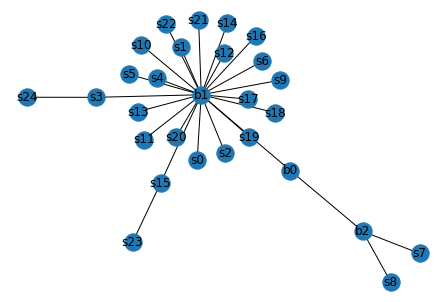

In [4]:
import networkx_utils as xu

"""
Purpose: To turn a group of meshes into a graph connectivity

Pseudocdoe: 
1) For each mesh:
a. make it the main mesh and find the meshes that are connected
b. add these as edges to a running list
2) create a networkx graph from the edges

How to determine whih parts that are the shaft
1) start with biggest shaft
2) Find the shoftest paths to all shaft parts
3) add all the nodes that aren't already in the shaft category to the shaft category

"""
import networkx as nx

spine_mesh_names = [f"s{i}" for i,mesh in enumerate(spine_meshes)]
shaft_mesh_names = [f"b{i}" for i,mesh in enumerate(shaft_meshes)]

total_meshes = spine_meshes + shaft_meshes
total_meshes_idx = spine_meshes_idx + shaft_meshes_idx
total_names = spine_mesh_names + shaft_mesh_names

total_edges = []
for j,(curr_mesh,curr_mesh_idx) in enumerate(zip(total_meshes,total_meshes_idx)):
    touching_meshes = tu.mesh_pieces_connectivity(
                    main_mesh=current_mesh,
                    central_piece=curr_mesh_idx,
                    periphery_pieces=total_meshes_idx)
    touching_meshes.remove(j)
    #construct the edges
    curr_edges = [[total_names[j],total_names[h]] for h in touching_meshes]
    total_edges += curr_edges

spine_graph = xu.remove_selfloops(nx.from_edgelist(total_edges))
nx.draw(spine_graph,with_labels=True)




In [5]:


"""
How to determine whih parts that are the shaft
1) start with biggest shaft
2) Find the shoftest paths to all shaft parts
3) add all the nodes that aren't already in the shaft category to the shaft category
"""

#find the biggest shaft
biggest_shaft = f"b{np.argmax([len(k.faces) for k in shaft_meshes])}"
non_biggest_shaft = [k for k in shaft_mesh_names if k != biggest_shaft]

#find all shortest paths from biggest shaft to non_biggest_shaft
shaft_shortest_paths = [nx.shortest_path(spine_graph,
                                         source=biggest_shaft,target=curr_shaft) for curr_shaft in non_biggest_shaft]

new_shaft_meshes = [int(k[1:]) for k in np.unique(np.concatenate(shaft_shortest_paths)) if "s" in k]
final_shaft_meshes = shaft_meshes + [spine_meshes[k] for k in new_shaft_meshes]
final_shaft_meshes_idx = np.unique(np.concatenate(shaft_meshes_idx + [spine_meshes_idx[k] for k in new_shaft_meshes]))
final_spine_faces_idx = np.setdiff1d(np.arange(0,len(current_mesh.faces)), final_shaft_meshes_idx)



In [6]:


"""
Subtract the shaft mesh and then get all the disconnected components
"""

spine_submesh = current_mesh.submesh([final_spine_faces_idx],append=True)
spine_submesh_split = spine_submesh.split(only_watertight=False)



# Testing the Different Spines found

In [8]:
#have a size threshold for them
spine_n_faces_lower_bound = 50
correct_spine = [4,5,6,7,8,9,13,14,15,16,17,18,19,20,21]
correct_spine_double_kissing_head = [10]
correct_spine_double_connected_stem = [4]
coorect_spine_fat_head = [17]
keep_spines = [2]
false_spine = [0]
small_stubs = [1,3,11.22]
shaft_patch = [0,12]
k = 22
v = spine_submesh_split[k]


In [9]:

print(f"Spine {k}: face length = {len(v.faces)}")
sk.graph_skeleton_and_mesh(other_meshes = [current_mesh,v],
                          other_meshes_colors=["white","red"],
                          mesh_alpha=0.3)


Spine 22: face length = 6


In [10]:
print(f"Spine {k}: face length = {len(v.faces)}")
sk.graph_skeleton_and_mesh(other_meshes = [v],
                          other_meshes_colors=["red"],
                          mesh_alpha=1)






Spine 22: face length = 6


In [11]:
"""
issues that can run into:
1) false spines at end of the branch

"""




#Future Work

"""
1) can use synapses to try and find ones that missed? or confirm ones that 
2) CAN USE A SKELETONIZATION TO LOOK FOR THE REALLY FAT SPINES


"""

Spine 22: face length = 6


'\n1) can use synapses to try and find ones that missed? or confirm ones that \n2) CAN USE A SKELETONIZATION TO LOOK FOR THE REALLY FAT SPINES\n\n\n'

# Putting all the steps together

In [ ]:
current_neuron = recovered_neuron
branch_idx = 0
limb_idx = 0

spine_submesh_split = get_spine_meshes(current_neuron = recovered_neuron,
                                        limb_idx=limb_idx,
                                        branch_idx=branch_idx,
                                        clusters=2,
                                        smoothness=0.05,
                                        cgal_folder = Path("./cgal_temp"),
                                        delete_temp_file=True):


# Actually graphing the spines

In [ ]:
#have a size threshold for them
spine_n_faces_lower_bound = 50
correct_spine = [4,5,6,7,8,9,13,14,15,16,17,18,19,20,21]
correct_spine_double_kissing_head = [10]
correct_spine_double_connected_stem = [4]
coorect_spine_fat_head = [17]
keep_spines = [2]
false_spine = [0]
small_stubs = [1,3,11.22]
shaft_patch = [0,12]
k = 22
v = spine_submesh_split[k]


print(f"Spine {k}: face length = {len(v.faces)}")
sk.graph_skeleton_and_mesh(other_meshes = [current_mesh,v],
                          other_meshes_colors=["white","red"],
                          mesh_alpha=0.3)